### 0. Imports

In [35]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.data_visualization_support as dvs
import src.association_metrics as am

# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr


# avoid "trivial" warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("once")
warnings.simplefilter('ignore', (FutureWarning))


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Introduction - Employee Retention - Exploration

After having evaluated some models in `notebooks/4_model_evaluation.ipynb`, it is interesting to further refine the exploratory data analysis from `notebooks/2_EDA.ipynb` to extract new insights that could be useful for business but also to improve the models now available.

### 1.1 Data import

In [36]:
pd.reset_option("display.max_columns")
employee_attrition = pd.read_pickle("../data/explored/employee_attrition_explored.pkl")
employee_attrition.head()

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,gender,joblevel,jobrole,...,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


# 2. EDA

## 2.1 Questions to answer during analysis

## 2.2 Multivariate relationships - target to numerical

During EDA, some interesting relationships were observed in the target feature with regards to some numerical features, especiallly; Age, total working years and years at company.

Looking at them again:

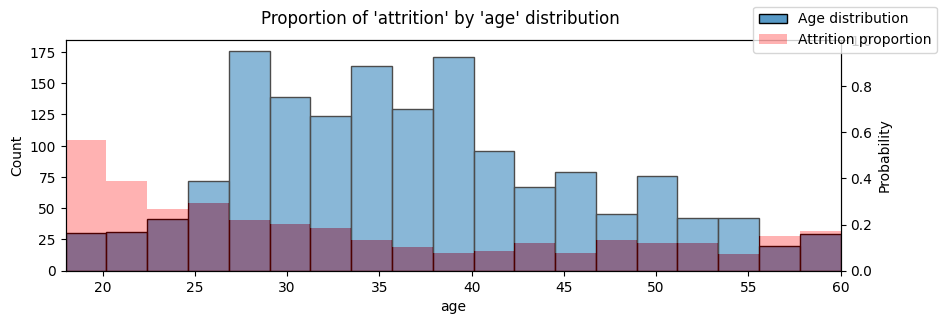

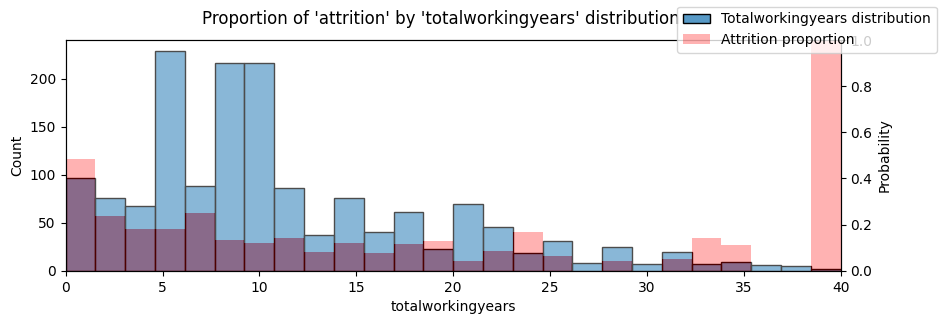

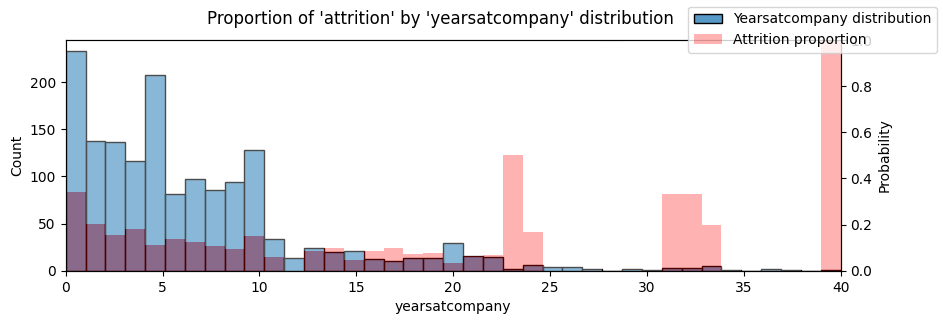

In [63]:
repl_dict = {'Yes': 1, 'No': 0}

for feature in ["age","totalworkingyears","yearsatcompany"]:
    se.plot_combined_target_distribution(employee_attrition, "attrition", feature, repl_dict=repl_dict, figsize=(10,3))

It is clear that there is a pattern. Let's confirm it by running a rank point biserial for monotonical association: 

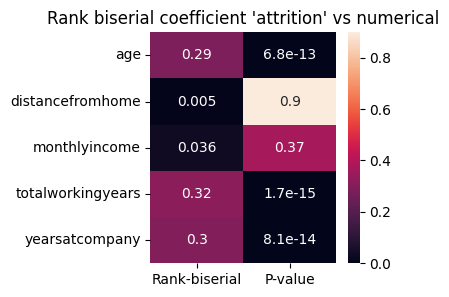

In [64]:
employee_attrition_bin = employee_attrition.replace(repl_dict)

# impute in this copy for EDA
employee_attrition_bin["totalworkingyears"].fillna(employee_attrition_bin["totalworkingyears"].mode().iloc[0],inplace=True)

# calculate rank biserial and plot heatmap
rank_biserial = se.calculate_rank_biserial(employee_attrition_bin, "attrition", 
                                           employee_attrition.select_dtypes(["int64","float64"])
                                           .columns.to_list())
plt.figure(figsize=(3,3))
plt.title("Rank biserial coefficient 'attrition' vs numerical")
sns.heatmap(rank_biserial, annot=True)
plt.show()

We can confirm that correlations with monthlyincode and distance from home not only are not strong but also not significant. The three other associations that we are analysing are relatively high, for this type of problem, and also significant. Given that they show similar coefficients, it is worth looking into their pairwise relationships:

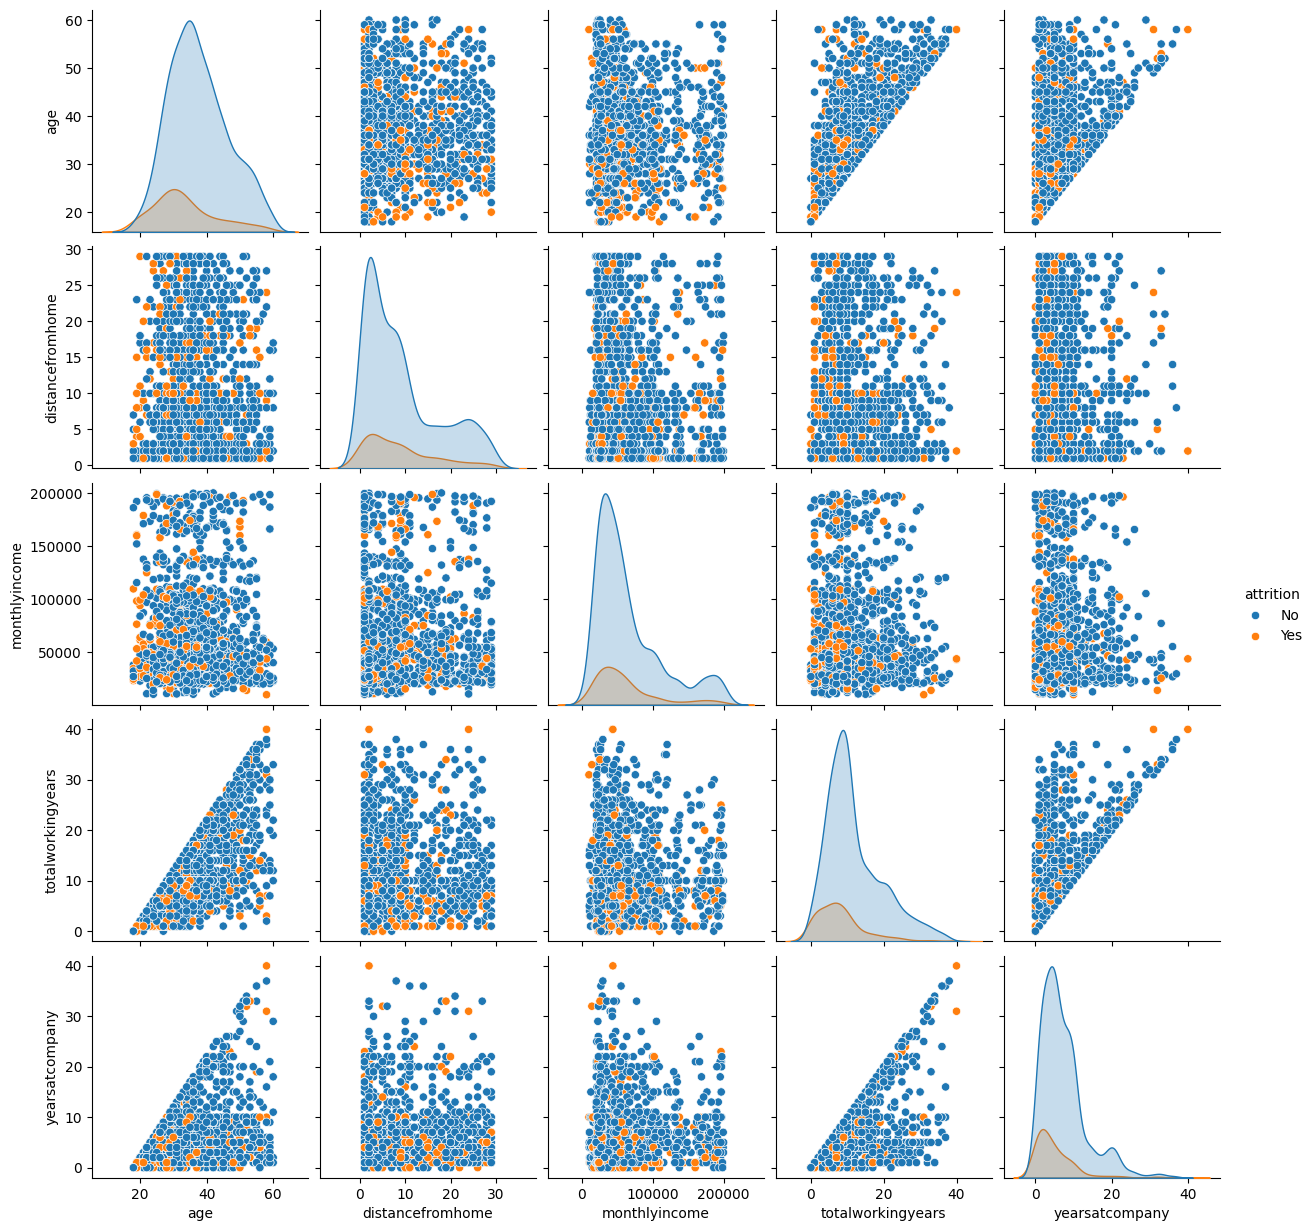

In [39]:
numerical_plus_attrition = employee_attrition.select_dtypes(np.number).columns.to_list() + ["attrition"]
sns.pairplot(employee_attrition[numerical_plus_attrition], hue="attrition")

Through pairplots we can see that years at company are limited by the total working years and the age, which makes total sense. To make sure, let's inspect their correlation coefficients.

<Axes: >

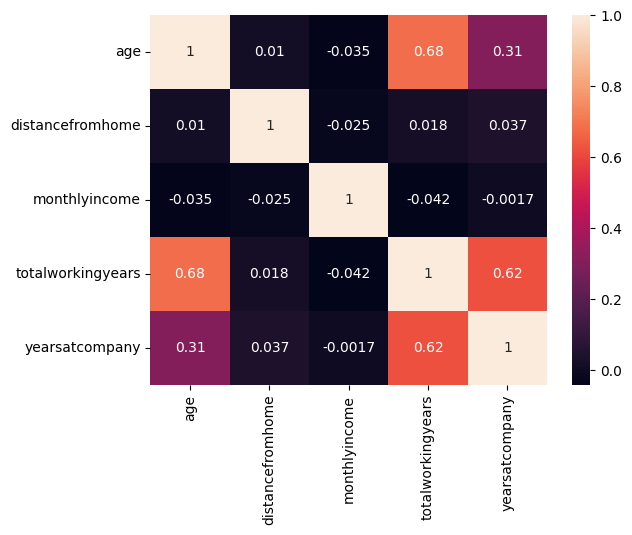

In [40]:
sns.heatmap(employee_attrition.corr(numeric_only=True), annot=True)

Here we see that Age correlates most with the total working years, as employees can arrive to the company later on in life. It looks that, even though there's redundancy in these features, the interplay with respect to the target is obvious. 

To put it simply; The more working experience a person is, the more professionally mature. The more aged they are, the more personally mature. And finally, the longer they have stayed in the company, the more attached they feel to it.

## 2.2 Multivariate relationships - target to categorical

During the first EDA, some features were visually deemed as significant for their relationship with the target. Mainly; Business travel, department, maritalstatus, numcompaniesworked, yearswithcurrentmanager and the employee satisfaction family.

The following heatmap shows only the significant pairwise relationship between categorical features through a chi-squared test, quantified for the magnitude of their effect via the cramer's V coefficient.

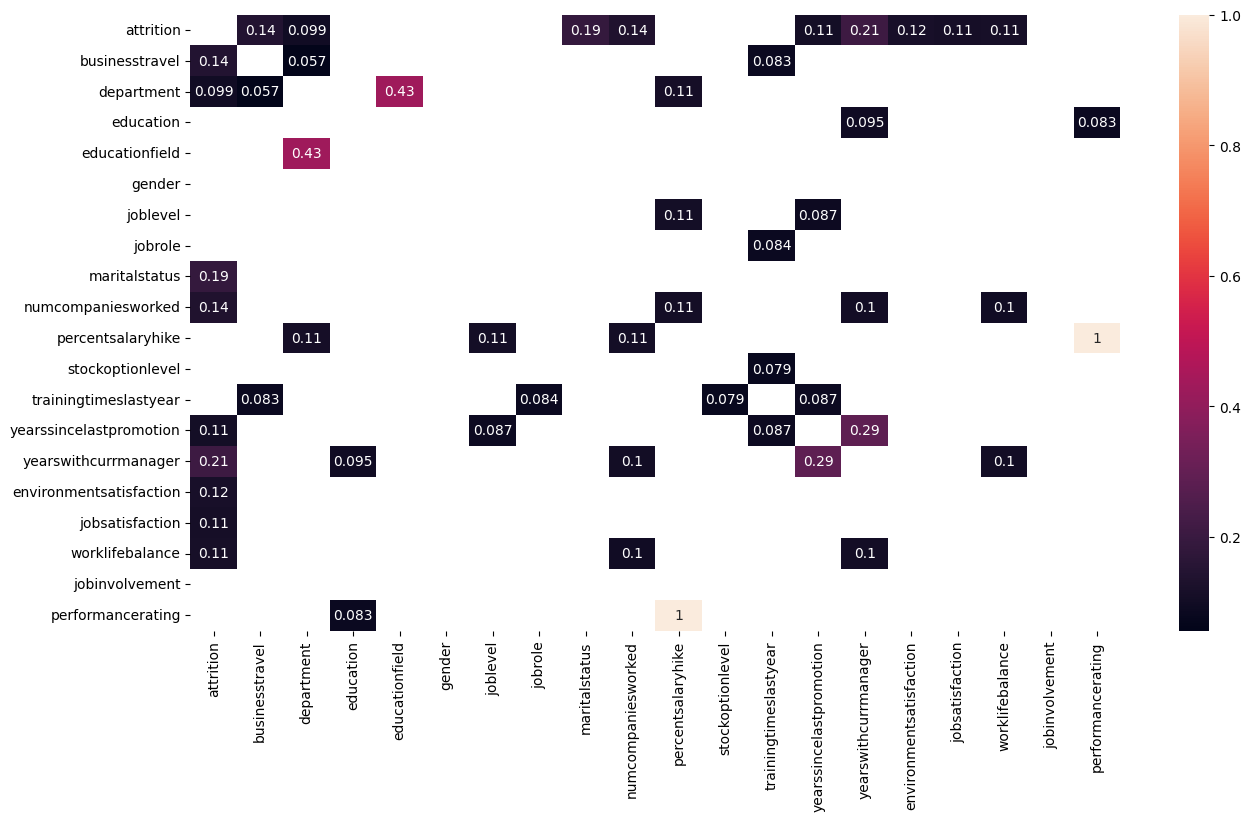

In [41]:
cramer = am.CramersV(correction=True)

# input dataframe object types as category
cramers_v_matrix, p_value_matrix = cramer.fit_transform(employee_attrition.select_dtypes("object").astype("category"))

# plot only significant relationships
plt.figure(figsize=(15,8))
sns.heatmap(cramers_v_matrix[p_value_matrix < 0.05],annot=True)
plt.show()

Here, we can see that the main effects with the target feature coincide with the above mentioned. The biggest effects come from the number of years with the current manager, the marital status, business travel and number of companies worked. 

As explained in the last EDA, years with current manager could promote loyaty through bonding. Marital status is related to the need for stability or lack thereof. Business travel can wear employees off. And finally employees who just started their careers or are job hoppers have a higher tendency to turnover.

Since marital status is a big main effect and so is business travel, it might make sense that married employees that travel a lot suffer this more than singles. Let's observe it:

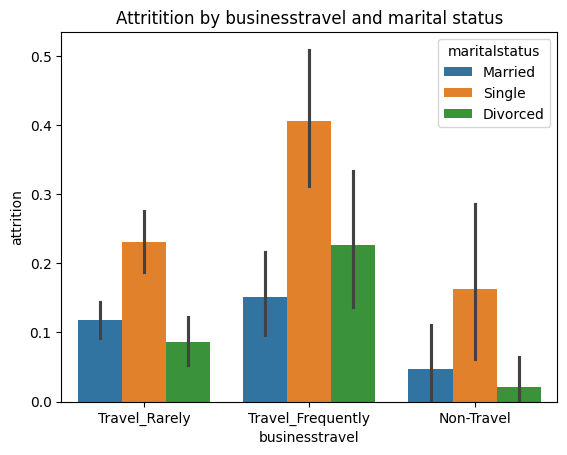

In [42]:
plt.title("Attritition by businesstravel and marital status")
sns.barplot(data=employee_attrition_bin,
            x="businesstravel",
            y="attrition",
            hue="maritalstatus"
            )
plt.show()

Contrary to what priorly thought, the emotional and energy wear of constant travel gets multiplied by the same correlation of maritalstatus. That is, single people turnover more, employees who travel frequently also, those who do both are a ticking bomb.

Let's see the interaction with age:

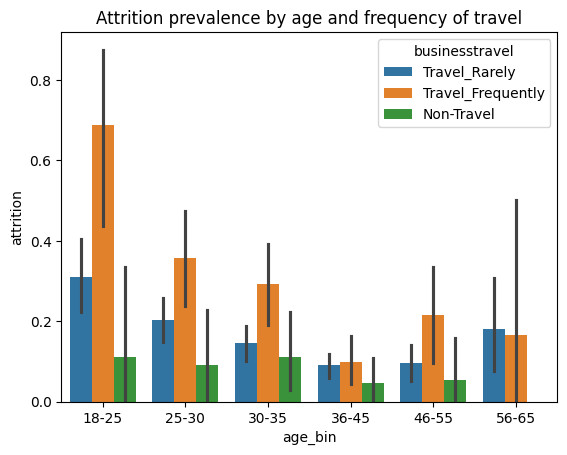

In [46]:
# Create binnings for easier visualization
bins = [18, 25, 30, 35, 45, 55, 65]  
labels = ["18-25","25-30", "30-35", "36-45", "46-55", "56-65"] 

# Binning ages
employee_attrition_bin["age_bin"] = pd.cut(
    employee_attrition_bin["age"],
    bins=bins,
    labels=labels,
    right=True,  # includes the upper bound in the bin
)

plt.title("Attrition prevalence by age and frequency of travel")
sns.barplot(data=employee_attrition_bin,
            x="age_bin",
            y="attrition",
            hue="businesstravel"
            )
plt.show()

Same as with marital status, the effect from both categories sees itself nothin but intensified when combined. Some business travel is inevitable, but it might be worth planning who is sent too frequently as, judging from the Cramer's V matrix, there is no significant correlation with joblevel but maybe with department and training times.

Coming back to the main effects, let's see what other categorical features might be related to. Starting by numcompaniesworked:

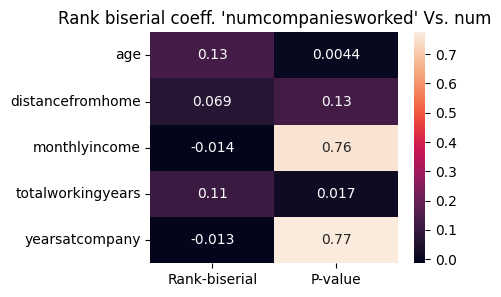

In [60]:
employee_attrition_bin = employee_attrition.copy()
employee_attrition_bin["numcompaniesworked"] = employee_attrition_bin["numcompaniesworked"].fillna(0).astype("float")

# impute in this copy for EDA
employee_attrition_bin["totalworkingyears"].fillna(employee_attrition_bin["totalworkingyears"].mode().iloc[0],inplace=True)


rank_biserial = se.calculate_rank_biserial(employee_attrition_bin, "numcompaniesworked", 
                                           employee_attrition.select_dtypes(["int64","float64"])
                                           .columns.to_list())

plt.figure(figsize=(4,3))
plt.title("Rank biserial coeff. 'numcompaniesworked' Vs. num")
sns.heatmap(rank_biserial, annot=True)
plt.show()

It is not surprising that totalworkingyears and age are the only significant relationships. Years with current manager was also very correlated with this one. We are back to the same conclusion, professional and personal maturity helps prevent attrition. 

Therefore, career plans that not only promote professional growth but personal growth and allow employees to feel at home are recommended for the company.